---

## Capstone Part 4 - Modelling

---

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import time
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer

stops = list(stopwords.words("english"))

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
hail_data_final = pd.read_csv("./hail_data_final.csv")
hail_data_final.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
# Note these terms were added into stopwords list after the topic modelling (later in the report) as they
# were distorting the groupings
stops.append('youtube')
stops.append('video')
stops.append('via')
stops.append('de')
stops.append('done')
stops.append('amp')
stops.append('like')
stops.append('keep')
stops.append('go')
stops.append('gt')

In [7]:
# Use function from capstone part2 to clean twitter data

def clean_tweet(tweet):

    #Remove links from tweet
    link_remove = re.sub(r"http\S+", "", tweet)
    
    #Remove non-letters from tweet    
    letters = re.sub("[^a-zA-Z]", " ", link_remove) 
    
    #Convert to lower case, split into individual words
    words = letters.lower().split()                             
    
    #Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    
    #Join the words back into one string separated by space and return the result.
    return (" ".join(meaningful_words))

In [8]:
# Initialize an empty list to hold the full parsed twitter dataset

clean_hail_data = []

# Loop over each tweet and append the cleanded tweet:

for tweet in hail_data_final["Text"]:
    clean_hail_data.append(clean_tweet(tweet))
    
print(clean_hail_data[:10])
print(len(clean_hail_data))

hail_data_final['tweet_words'] = clean_hail_data

['take lightning stroketo create ruin quoax', 'meliscward next storm night', 'daddymattyt tired sun raining viciously thunder lightning', 'dteenergy storm tip smoke carbon monoxide detectors level home close sleeping areas', 'wowrt reedtimmertvn happy thanksgiving incredible western ks sunset taken storm chaser dick mcgowan stormpics', 'one kind car excited lightning rod', 'task flood completed iphone iphonegames gameinsight', 'extension area winter storm warning issued november pm est november est nws', 'storm make sure family prepared download ready emergency preparedness app', 'nigeriainfoph nigerians understand level damage spoken word country nigeria never pblems']
145617


In [9]:
# Initialize the CountVectorizer

# In this updated version I also investigated 2 word ngrams to pick up any damage related terms
# such as "golf-ball" and "tennis-ball", however too many of the bigrams were obvious duplicates of the single terms
# so I reverted back to single words only.

print ("Creating words, please wait...\n")

vectorizer = CountVectorizer(analyzer = "word",tokenizer = None,stop_words = 'english',max_features = 1000) 

# fit_transform() does two functions: First, it fits the model

train_data_features = vectorizer.fit_transform(clean_hail_data)

columns = vectorizer.get_feature_names()

Creating words, please wait...



In [10]:
# Fit cvec and converting the result to a DataFrame.

words_df = pd.DataFrame(vectorizer.transform(clean_hail_data).todense(), columns=vectorizer.get_feature_names())

words_df.fillna(0)

print (words_df.shape)

(145617, 1000)


In [11]:
# Create the final hail_tweet_text dataframe

hail_tweet_text = pd.concat([hail_data_final, words_df], axis=1)
hail_tweet_text.shape

(145617, 1025)

In [12]:
hail_tweet_text = hail_tweet_text[hail_tweet_text['gemini']==0]

In [13]:
hail_tweet_text.to_csv('hail_tweet_text.csv')

## Introduce Sentiment Variable

In [14]:
from textblob import TextBlob, Word

def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [15]:
# create a new DataFrame column for sentiment (WARNING: SLOW!)
hail_tweet_text['sentiment'] = hail_tweet_text.Text.apply(detect_sentiment)

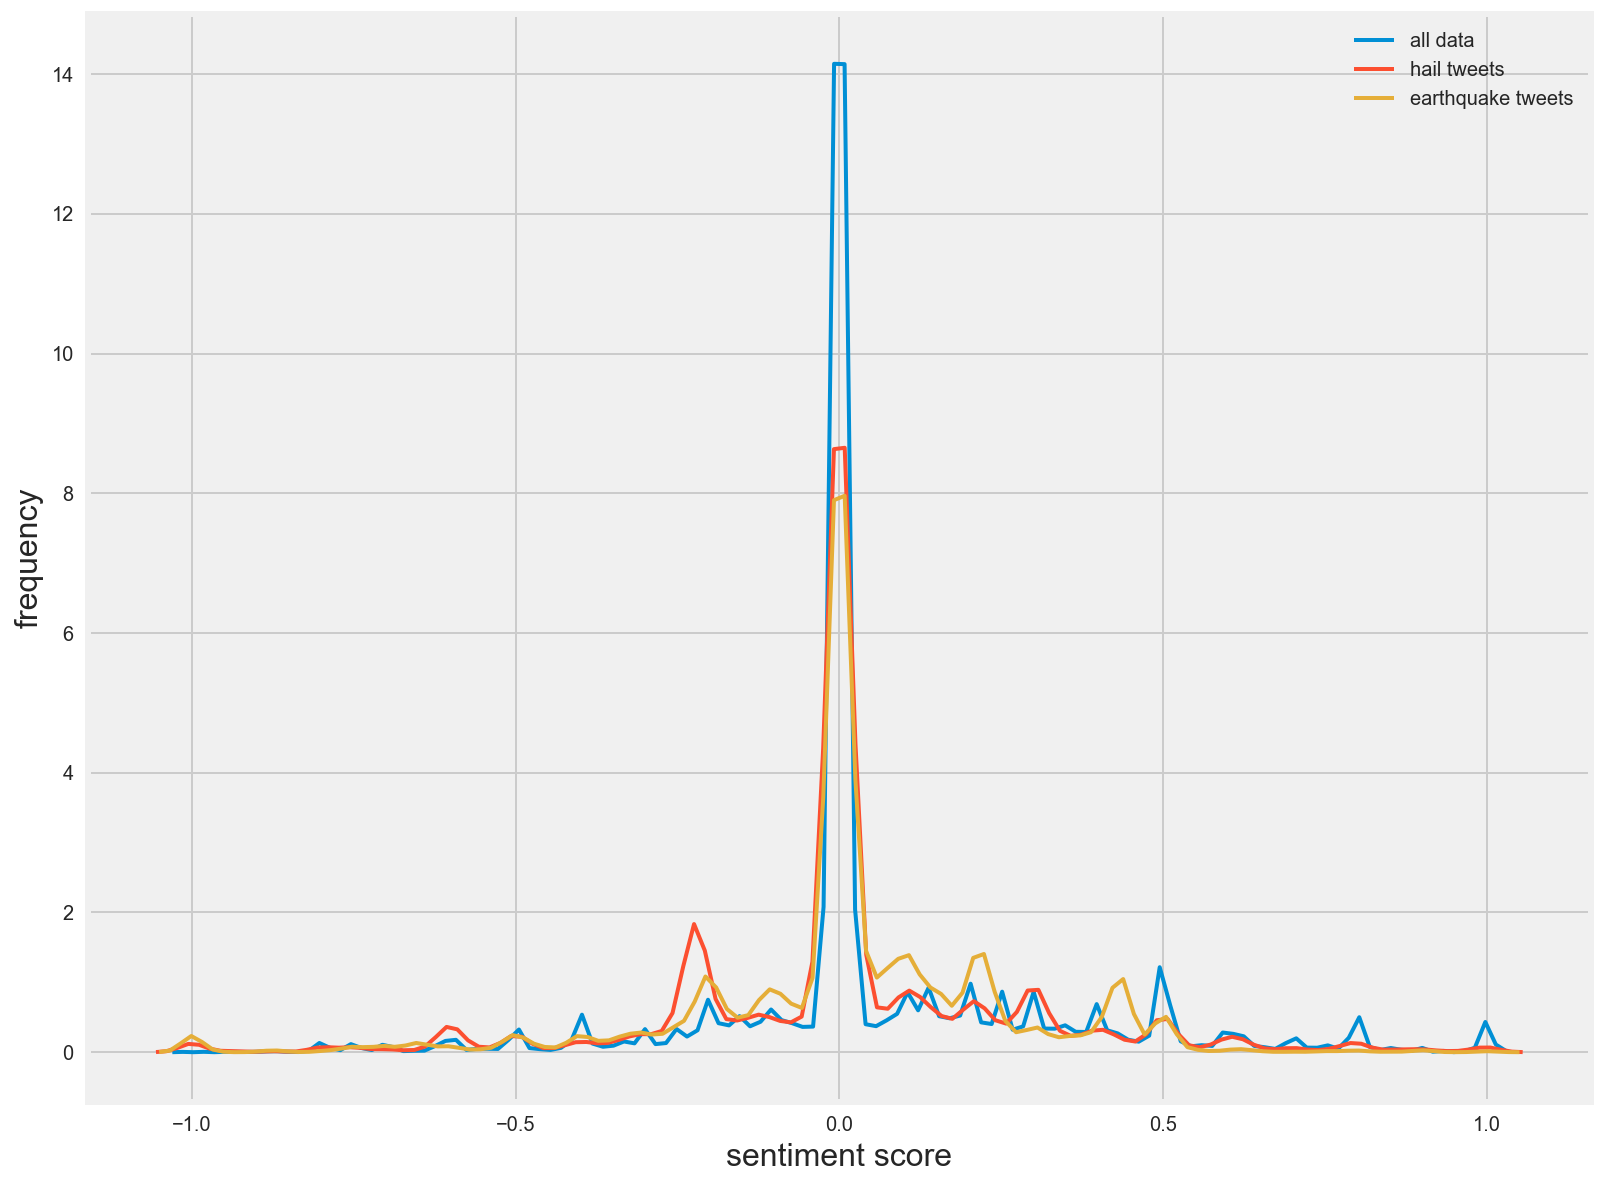

In [16]:
hail_tweets = hail_tweet_text.loc[hail_tweet_text['hail'] >= 1]
eq_tweets = hail_tweet_text.loc[hail_tweet_text['earthquake'] >= 1]

fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(hail_tweet_text['sentiment'],hist=False,kde_kws={"lw": 2, "label": "all data"})
sns.distplot(hail_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "hail tweets"})
sns.distplot(eq_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "earthquake tweets"})
ax.set_xlabel('sentiment score', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)

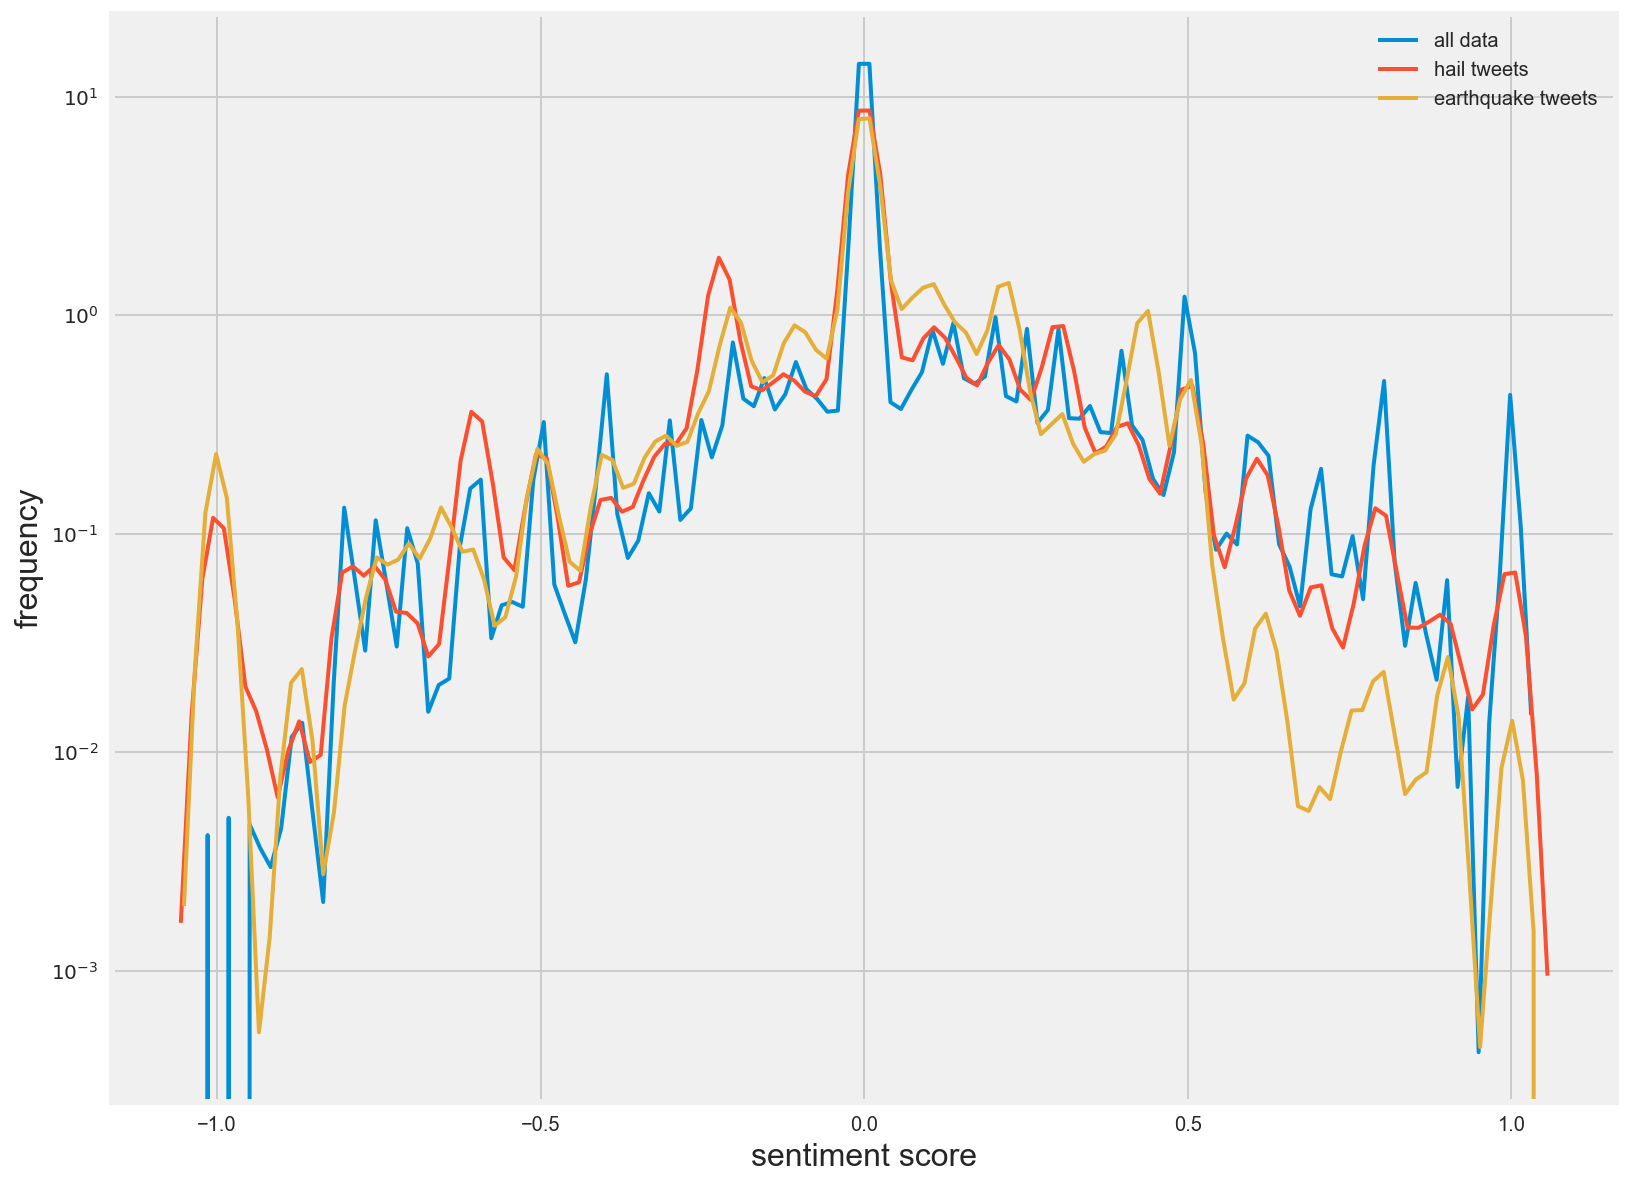

In [17]:
hail_tweets = hail_tweet_text.loc[hail_tweet_text['hail'] >= 1]
eq_tweets = hail_tweet_text.loc[hail_tweet_text['earthquake'] >= 1]

fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(hail_tweet_text['sentiment'],hist=False,kde_kws={"lw": 2, "label": "all data"})
sns.distplot(hail_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "hail tweets"})
sns.distplot(eq_tweets['sentiment'],hist=False,kde_kws={"lw": 2, "label": "earthquake tweets"})
ax.set_xlabel('sentiment score', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)
plt.yscale('log')

In [18]:
# hail_tweets = hail_tweet_text.loc[hail_tweet_text['hail'] >= 1]

# compute 95% confidence intervals around the mean  
# CIs = []

#for sent in hail_tweets.sentiment:
    #CI = []
    #conf_int = bootstrap.ci(data=sent, statfunction=scipy.mean)
    #CI.append(conf_int)
    #CIs.append(CI)

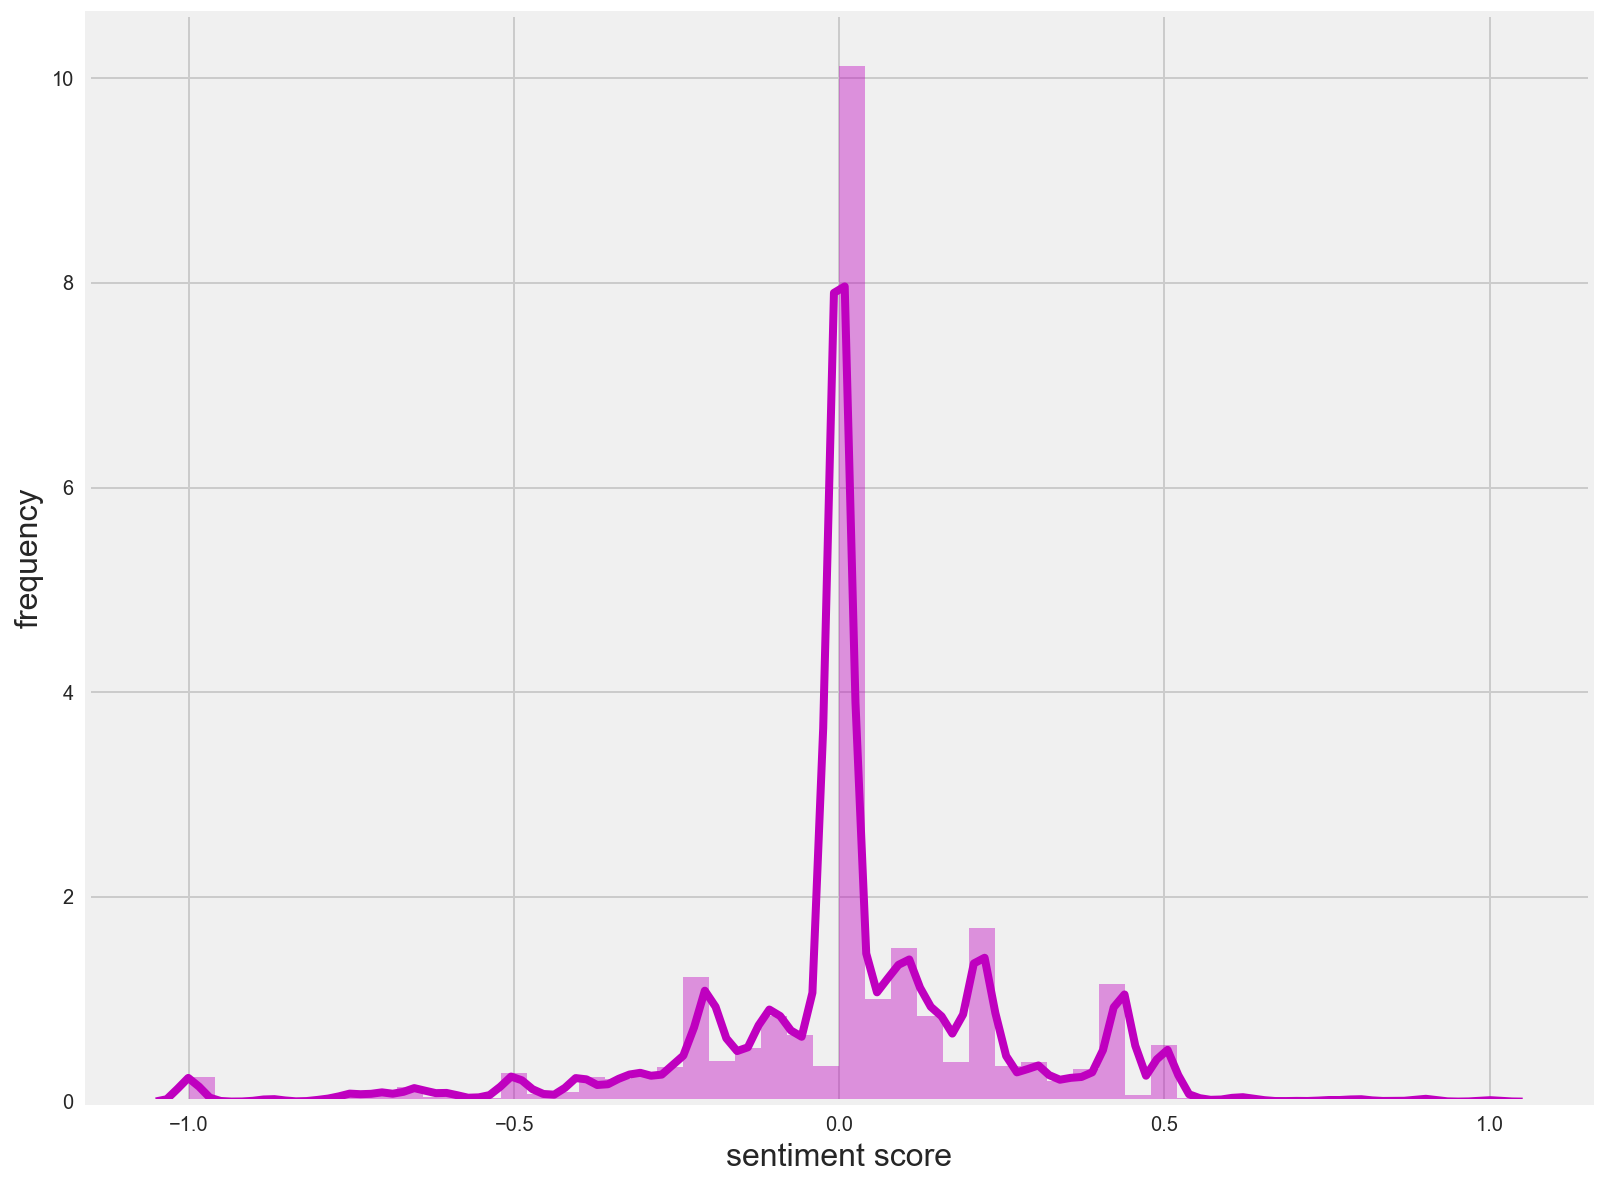

In [19]:
hail_tweets = hail_tweet_text.loc[hail_tweet_text['earthquake'] >= 1]

fig, ax = plt.subplots(figsize=(12,10))
sns.distplot(hail_tweets['sentiment'],color="m")
ax.set_xlabel('sentiment score', fontsize=16)
ax.set_ylabel('frequency', fontsize=16)

In [20]:
hail_tweet_text['sentiment'] = hail_tweet_text['sentiment']+1.0

## New Model Tests

In [21]:
# Import modelling libraries

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [22]:
# Create hail class for classification analysis

hail_tweet_text['hail_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'hail_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'hail_class'] = 1

hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID'] == 144]
hail_tweet_text_syd = hail_tweet_text[hail_tweet_text['Cat_ID'] == 154]

In [23]:
htt_total = hail_tweet_text.ix[:,25:]
print (htt_total.shape)
htt_bris = hail_tweet_text_bris.ix[:,25:]
print (htt_bris.shape)
htt_syd = hail_tweet_text_syd.ix[:,25:]
print (htt_syd.shape)

y_total = htt_total.hail_class
y_bris = htt_bris.hail_class
y_syd = htt_syd.hail_class

(127989, 1002)
(46529, 1002)
(81460, 1002)


In [24]:
htt_total.drop(htt_total[['hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_bris.drop(htt_bris[['hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_syd.drop(htt_syd[['hail','hailstorm','hail_class']], axis=1, inplace=True)

In [25]:
ss = StandardScaler()
Xs_htt_total = ss.fit_transform(htt_total)
Xs_htt_bris = ss.fit_transform(htt_bris)
Xs_htt_syd = ss.fit_transform(htt_syd)

In [26]:
# PCA On Full Dataset Set

pca = PCA()
pca.fit(Xs_htt_total)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pca.explained_variance_ratio_.max()

0.011817699957296963

In [28]:
htt_pcs = pca.transform(Xs_htt_total)
htt_pcs = pd.DataFrame(htt_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                       index=htt_total.index)

In [29]:
htt_pcs.index.values

array([     0,      1,      2, ..., 145614, 145615, 145616])

In [30]:
exp_var = pca.explained_variance_ratio_
exp_var

array([  1.18177000e-02,   8.91480273e-03,   8.19565954e-03,
         7.46361269e-03,   7.23141871e-03,   7.09129967e-03,
         5.42562860e-03,   5.04016984e-03,   4.91728415e-03,
         4.54401049e-03,   4.33646660e-03,   4.14560241e-03,
         4.05578786e-03,   3.97800466e-03,   3.74222918e-03,
         3.71172325e-03,   3.66404333e-03,   3.62293203e-03,
         3.54208278e-03,   3.38822684e-03,   3.34233840e-03,
         3.32603349e-03,   3.24128967e-03,   3.12567481e-03,
         2.96937783e-03,   2.88400933e-03,   2.87020320e-03,
         2.85905830e-03,   2.81766246e-03,   2.80112952e-03,
         2.72897037e-03,   2.67171149e-03,   2.65800099e-03,
         2.58449116e-03,   2.56873103e-03,   2.53981813e-03,
         2.45095465e-03,   2.45052892e-03,   2.41700891e-03,
         2.38712236e-03,   2.38061214e-03,   2.34008332e-03,
         2.32673531e-03,   2.28120519e-03,   2.27355684e-03,
         2.23172244e-03,   2.18217561e-03,   2.16264219e-03,
         2.14743688e-03,

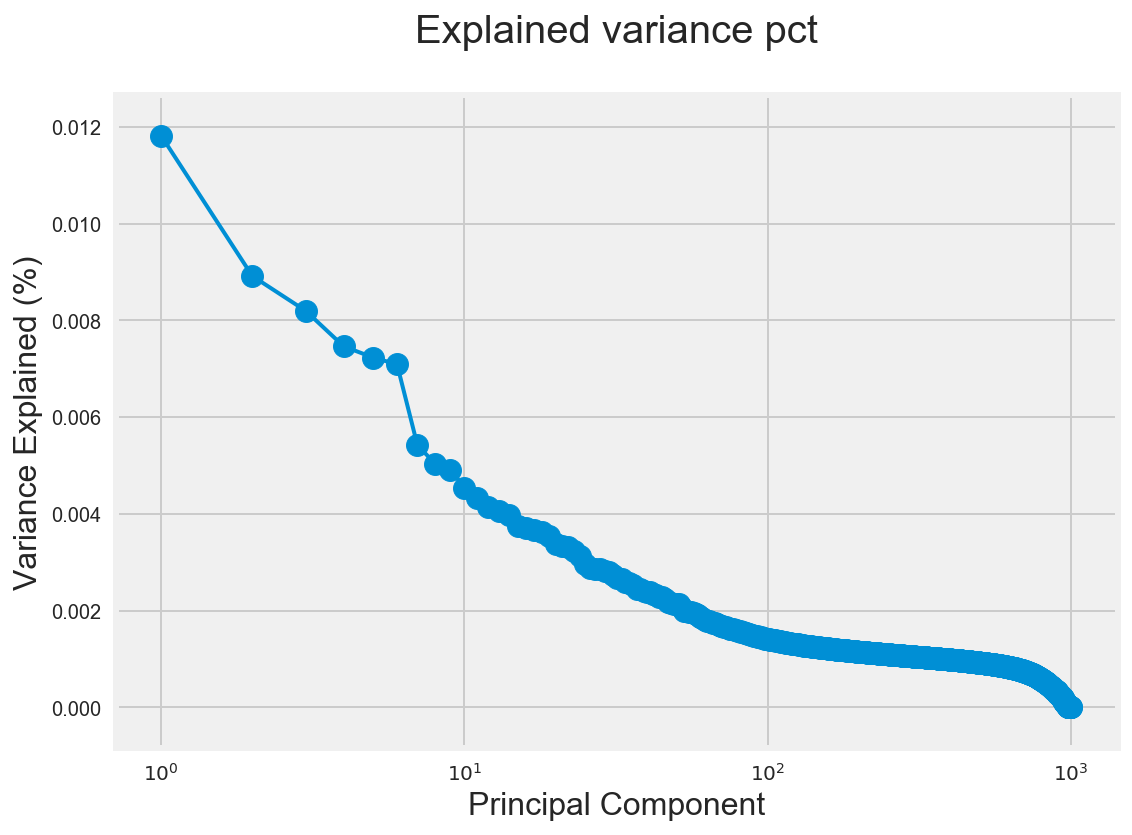

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.xscale('log')
plt.show()

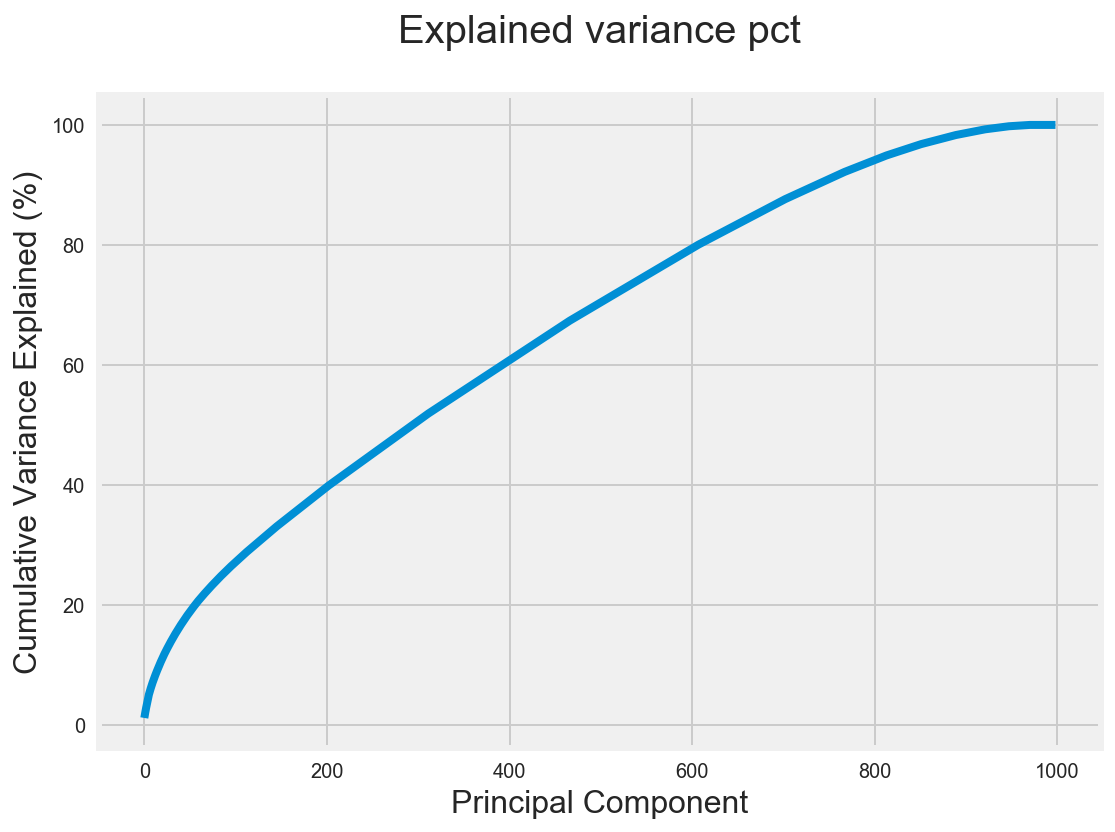

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=16)
plt.plot(var1)

In [33]:
components = pd.DataFrame(pca.components_,
                 columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                 index=htt_total.columns)
print (components['PC1'].nlargest(10))
print (components['PC2'].nlargest(10))
print (components['PC3'].nlargest(10))
print (components['PC4'].nlargest(10))
print (components['PC5'].nlargest(10))

wolf        0.806899
actually    0.351079
warnings    0.198002
bc          0.082580
warning     0.060594
spring      0.030308
tracking    0.029691
bbc         0.027228
state       0.024818
start       0.023783
Name: PC1, dtype: float64
social     0.180343
bitch      0.179145
blood      0.143140
sounds     0.109596
pic        0.096524
streets    0.092924
jackson    0.091375
plans      0.084884
nd         0.080404
close      0.079399
Name: PC2, dtype: float64
play             0.228584
ne               0.114115
dallas           0.109365
person           0.108719
look             0.105281
cover            0.102156
beta             0.101440
brisbanestorm    0.094502
pc               0.090226
morning          0.089013
Name: PC3, dtype: float64
big       0.251285
book      0.174737
stream    0.141384
stuck     0.139571
soar      0.138829
star      0.122271
beta      0.121544
song      0.105612
starts    0.105252
speed     0.104062
Name: PC4, dtype: float64
key           0.138568
low          

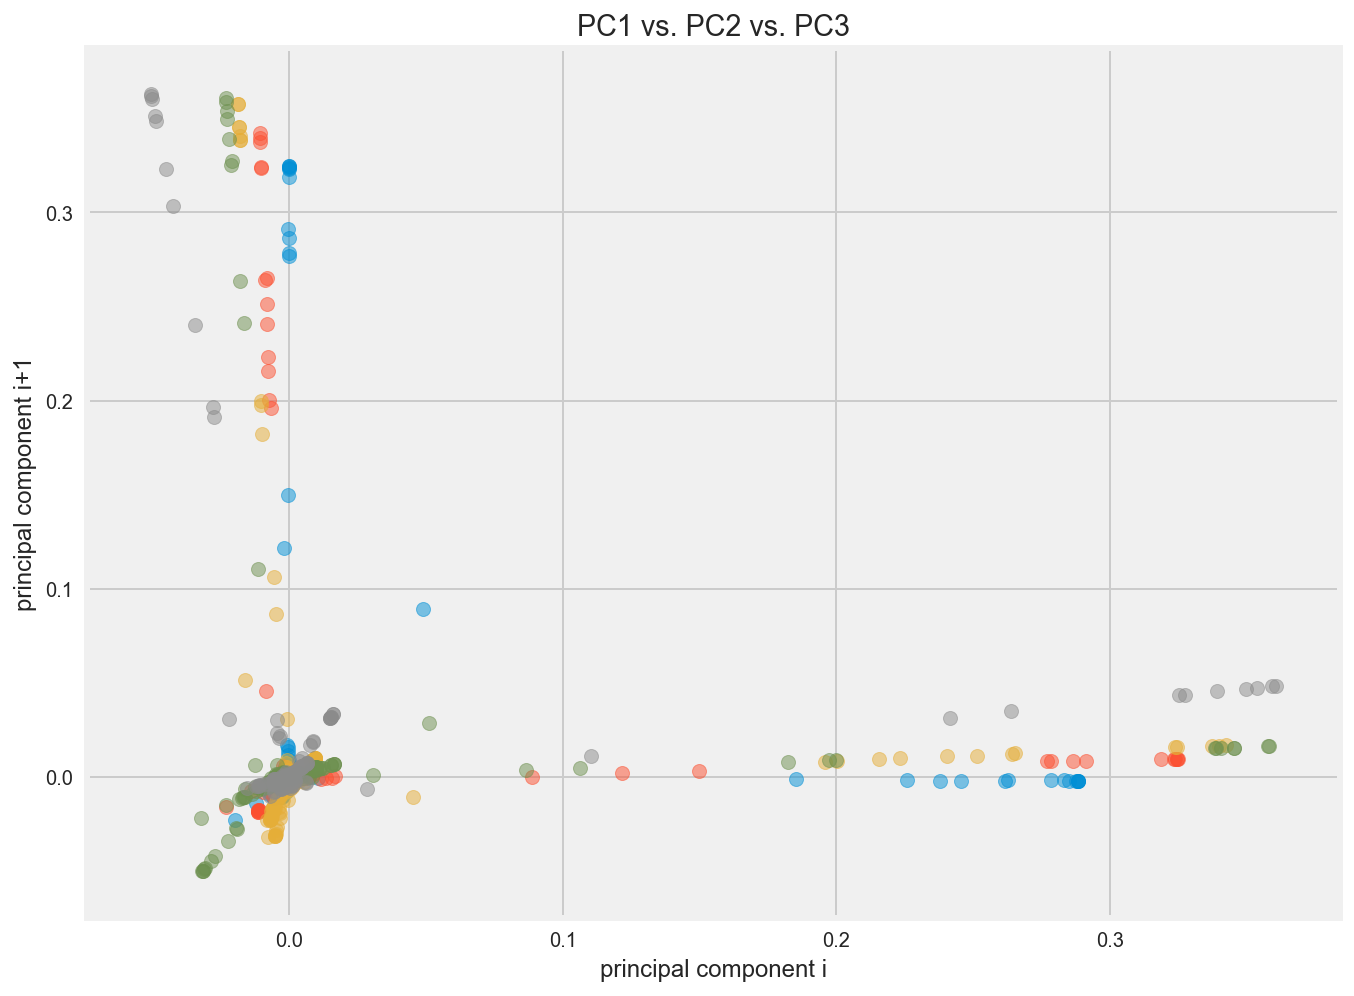

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5)
ax.scatter(pca.components_[1], pca.components_[2], alpha=0.5)
ax.scatter(pca.components_[2], pca.components_[3], alpha=0.5)
ax.scatter(pca.components_[3], pca.components_[4], alpha=0.5)
ax.scatter(pca.components_[4], pca.components_[5], alpha=0.5)
ax.set_title('PC1 vs. PC2 vs. PC3')
ax.set_xlabel('principal component i')
ax.set_ylabel('principal component i+1')
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(htt_pcs.PC1.values, htt_pcs.PC2.values, s=0)

for i, txt in enumerate(htt_pcs.index.values):
    ax.annotate(txt, (0, 0), (htt_pcs.PC1.values[i], htt_pcs.PC2.values[i]),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.5),
            xycoords='data', textcoords='data', fontsize=12, color="black")

ax.set_title('PC1 (below average) vs. PC2 (javelin))')
ax.set_xlabel('principal component 1 (below average)')
ax.set_ylabel('principal component 2 (javelin)')
plt.show()

### All Data - Naive Bayes

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

In [ ]:
mnb_tot = MultinomialNB()
mnb_tot.fit(X_total_tf, y_total)

In [101]:
mnb_tot_scores = cross_val_score(mnb_tot, X_total_tf, y_total, cv=5)

print (mnb_tot_scores)
print (sum(mnb_tot_scores)/len(mnb_tot_scores))

[ 0.9531604   0.9708571   0.96460661  0.96249707  0.96233934]
0.962692103597


In [103]:
# Create predicted y values

yhat_total_mnb = mnb_tot.predict(X_total_tf)
yhat_total_mnb_pp = mnb_tot.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_mnb == 1))
fp = np.sum((y_total == 0) & (yhat_total_mnb == 1))
tn = np.sum((y_total == 0) & (yhat_total_mnb == 0))
fn = np.sum((y_total == 1) & (yhat_total_mnb == 0))

# convert the predicted and actual values to a confusion array

confusion_array_mnb_total = np.array(confusion_matrix(y_total, yhat_total_mnb, labels=[1,0]))

confusion_mnb = pd.DataFrame(confusion_array_mnb_total, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_mnb

,predicted_hail,predicted_no_hail
hail,1331,3574
no hail,340,122744


In [104]:
mnb_tot.coef_.shape

(1, 998)

In [105]:
mb_coefficients = pd.DataFrame(data=mnb_tot.coef_,columns=htt_total.columns)
mb_coefficients = mb_coefficients.T
mb_coefficients.sort_values(0, ascending=False, inplace=True)
mb_coefficients

,0
sentiment,-1.787375
storm,-2.294622
sydney,-3.211194
brisbane,-3.238347
sydneystorm,-3.866321
massive,-4.388313
slammed,-4.486233
severe,-4.519756
rain,-4.588682
worst,-4.597911


### Bris/Syd Train/Test - Naive Bayes

In [118]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=False).fit(htt_bris)
Xs_bris_tf = tf_transformer.transform(htt_bris)
print(Xs_bris_tf.shape)

Xs_syd_tf = tf_transformer.transform(htt_syd)
print(Xs_syd_tf.shape)

(46529, 998)
(81460, 998)


In [119]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(Xs_bris_tf, y_bris)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [120]:
mnb_scores = cross_val_score(mnb, X_syd_tf, y_syd, cv=5)

print (mnb_scores)
print (sum(mnb_scores)/len(mnb_scores))

[ 0.96611834  0.96673214  0.96286521  0.96237417  0.96433833]
0.964485637123


In [121]:
# Create predicted y values

yhat_syd_mnb = mnb.predict(X_syd_tf)
yhat_syd_mnb_pp = mnb.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_mnb == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_mnb == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_mnb == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_mnb == 0))

# convert the predicted and actual values to a confusion array

confusion_array_mnb = np.array(confusion_matrix(y_syd, yhat_syd_mnb, labels=[1,0]))

confusion_mnb = pd.DataFrame(confusion_array_mnb, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_mnb

,predicted_hail,predicted_no_hail
hail,33,3142
no hail,1561,76724


In [122]:
# Create predicted y values

yhat_bris_mnb = mnb.predict(X_bris_tf)
yhat_bris_mnb_pp = mnb.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_mnb == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_mnb == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_mnb == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_mnb == 0))

# convert the predicted and actual values to a confusion array

confusion_array_mnb = np.array(confusion_matrix(y_bris, yhat_bris_mnb, labels=[1,0]))

confusion_mnb = pd.DataFrame(confusion_array_mnb, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_mnb

,predicted_hail,predicted_no_hail
hail,849,881
no hail,86,44713


### SGD Classification 

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha': (0.0001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'n_iter': (10, 50, 80),
}

sgd = SGDClassifier(loss='modified_huber')

sgd_gs = GridSearchCV(sgd, parameters, cv=5, verbose=1, refit=True)

sgd_gs.fit(X_total_tf, y_total)

print (sgd_gs.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.6min finished


{'alpha': 0.0001, 'n_iter': 50, 'penalty': 'l2'}


In [37]:
sgd_tot_scores = cross_val_score(sgd_gs, X_total_tf, y_total, cv=5)

print (sgd_tot_scores)
print (sum(sgd_tot_scores)/len(sgd_tot_scores))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.2min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


[ 0.96691148  0.97034925  0.9694898   0.96980233  0.95737782]
0.966786134681


In [38]:
# Create predicted y values

yhat_total_sgd = sgd_gs.predict(X_total_tf)
yhat_total_sgd_pp = sgd_gs.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_sgd == 1))
fp = np.sum((y_total == 0) & (yhat_total_sgd == 1))
tn = np.sum((y_total == 0) & (yhat_total_sgd == 0))
fn = np.sum((y_total == 1) & (yhat_total_sgd == 0))

# convert the predicted and actual values to a confusion array

confusion_array_sgd_total = np.array(confusion_matrix(y_total, yhat_total_sgd, labels=[1,0]))

confusion_sgd = pd.DataFrame(confusion_array_sgd_total, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_sgd

,predicted_hail,predicted_no_hail
hail,1975,2930
no hail,537,122547


### Decision Tree - Total File

In [123]:
# Decision Tree gridsearch to get the optimal decision tree model

dtc_params = {
    'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]}

from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, refit=True)

dtc_gs.fit(X_total_tf, y_total)

dtc_best = dtc_gs.best_estimator_

print (dtc_gs.best_params_)
print (dtc_gs.best_score_)

Fitting 5 folds for each of 847 candidates, totalling 4235 fits


[Parallel(n_jobs=1)]: Done 4235 out of 4235 | elapsed: 21.0min finished


{'max_depth': 10, 'max_features': None, 'min_samples_split': 15}
0.968106634164


In [124]:
# Validate Decision tree model and R^2
# Notebook output may differ due to original gridsearch CV iterations

dtr_ds = DecisionTreeClassifier(max_features=None,min_samples_split=3,max_depth=10)

dtr_ds.fit(X_total_tf, y_total)

dtr_ds_scores = cross_val_score(dtr_ds, X_total_tf, y_total, cv=5)

# Export scores of validated model

print (dtr_ds_scores)
print (sum(dtr_ds_scores)/len(dtr_ds_scores))

[ 0.96730213  0.98062349  0.96933354  0.96906008  0.95335391]
0.96793463047


In [125]:
# Extract the top features from the decision tree classifier.

top_features_DS = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':dtr_ds.feature_importances_})

top_features_DS.sort_values('importance', ascending=False, inplace=True)
top_features_DS.head(10)

,feature,importance
830,sydney,0.259150
98,brisbane,0.227582
831,sydneystorm,0.065134
132,causes,0.058281
762,slammed,0.048676
758,sized,0.047610
802,storm,0.041234
966,winds,0.036527
757,size,0.027356
442,large,0.017199


In [126]:
# Create predicted y values for decision tree analysis 

yhat_bris_dts = dtr_ds.predict(X_total_tf)
yhat_bris_dts_pp = dtr_ds.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_bris_dts == 1))
fp = np.sum((y_total == 0) & (yhat_bris_dts == 1))
tn = np.sum((y_total == 0) & (yhat_bris_dts == 0))
fn = np.sum((y_total == 1) & (yhat_bris_dts == 0))

# convert the predicted and actual values to a confusion array

confusion_array_dts = np.array(confusion_matrix(y_total, yhat_bris_dts, labels=[1,0]))

confusion_dts = pd.DataFrame(confusion_array_dts, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_dts

,predicted_hail,predicted_no_hail
hail,2187,2718
no hail,193,122891


### Random Forest

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_total_tf, y_total)

rfc_scores = cross_val_score(rfc_gs, X_total_tf, y_total, cv=5)

# Export scores of validated model

print (rfc_scores)
print (sum(rfc_scores)/len(rfc_scores))

[ 0.96671615  0.98058442  0.96913821  0.96851317  0.95944837]
0.968880064445


In [146]:
rfc_gs

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [148]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc.fit(X_total_tf, y_total)

top_features_rfc = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
top_features_rfc.head(20)

,feature,importance
830,sydney,0.104055
98,brisbane,0.058597
997,sentiment,0.040499
802,storm,0.040132
831,sydneystorm,0.031361
142,chaos,0.020288
758,sized,0.018045
979,worst,0.016107
762,slammed,0.015561
823,super,0.012040


In [149]:
# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc.predict(X_total_tf)
yhat_total_rfc_pp = rfc.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc

,predicted_hail,predicted_no_hail
hail,4313,592
no hail,57,123027


In [144]:
# Extract fundamental classifier metrics

print ("accuracy:", accuracy_score(y_total, yhat_total_rfc)) # accuracy = (tp + tn) / total_population)
print ("false positive rate", float(fp) / (tn + fp))
print ("specificity", float(tn) / (tn + fp))
print ("------")
print (classification_report(y_total, yhat_total_rfc))
# Precision = True Positives / (True Positives + False Positives)

accuracy: 0.995085515161
false positive rate 0.000438724773326
specificity 0.999561275227
------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    123084
          1       0.99      0.88      0.93      4905

avg / total       1.00      1.00      0.99    127989



### Brisbane Train / Sydney Test  - Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=20, bootstrap=False, criterion='gini', max_depth=None, max_features=10,
                            min_samples_leaf=1, min_samples_split=10)

rfc.fit(Xs_bris_tf, y_bris)

rfc_scores = cross_val_score(rfc, X_syd_tf, y_syd, cv=5)

print (rfc_scores)
print (sum(rfc_scores)/len(rfc_scores))

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd